In [1]:
%matplotlib inline

In [285]:
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# IMDB Movie Rating Prediction

## Author: Tsvetan Dimitrov

## Abstract

The goal of this analysis is to determine if there are any correlations between features of movies from IMDB that can help predict their ratings. A dataset consisting of 5000 IMDB movies and related metadata will be used, cleaned and processed in different ways to extract different types of features, e.g. numeric, categorical, related, etc. Different machine learning regression algorithms will be applied and compared with baseline defaults and grid search optimized versions in order to determine if we can truly predict movie ratings based on this metadata.

## Data Cleanup

Our first step is to read our dataset and apply some basic data cleaning. 

In [103]:
movie_data = pd.read_csv('data/movie_metadata.csv')
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


Let us count how many empty observations do we have and drop them because they will skew our models.

In [104]:
def count_nan_values(dataset):
    return dataset.apply(lambda x: sum(x.isnull()), axis=0)

count_nan_values(movie_data)

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [105]:
movie_data.dropna(how='any', inplace=True)

Another good idea is to remove any duplicates that could lead to a stronger bias and hence overfitting.

In [106]:
def count_duplicate_rows(dataset):
    return len([i for i in dataset.duplicated() if i == True])

print('Duplicates count:', count_duplicate_rows(movie_data))

# Drop duplicate rows
movie_data.drop_duplicates(inplace=True)

Duplicates count: 33


Finally we can group features and labels. The features __'aspect_ratio'__ and __'movie_imdb_link'__ tell us nothing about is a movie good or not, so we will drop them. __'imdb_score'__ will contain our labels so we need to drop it from the feature set and set is as labels.

In [349]:
movie_features = movie_data.drop(['imdb_score', 'aspect_ratio', 'movie_imdb_link'], axis=1)
movie_labels = movie_data.imdb_score
print('Features shape', movie_features.shape)
print('Labels shape', movie_labels.shape)

Features shape (3723, 26)
Labels shape (3723,)


## Train and Evaluate Procedures
In this section we will prepare some code that will be reused later. 
* `dataset_split` is a function performing a dataset train-test split in a 80-20 ratio. 
* `score_model` is a function applying and scoring the accuracy of already trained models on top of the test split.
* `train_and_score_baseline_model` is a function that gathers training an algorithm with option defaults, applying the trained model and scoring it.
* `train_and_score_tunned_model` is a function that gathers training an algorithm with grid search optimized best estimator from a set of possible parameter values, applying the trained model and scoring it.

In [328]:
def dataset_split(features, labels):   
    features_train, features_test, labels_train, labels_test = train_test_split(
        features,
        labels,
        test_size=0.2,
        random_state=4
    )
    
    return {
        'train_features': features_train,
        'test_features': features_test, 
        'train_labels': labels_train,
        'test_labels': labels_test
    }

def score_model(dataset_split, model):
    train_score = model.score(dataset_split['train_features'], dataset_split['train_labels'])
    print('\tTraining score: ', train_score)
    
    test_score = model.score(dataset_split['test_features'], dataset_split['test_labels'])
    print('\tTesting score: ', test_score)

def train_and_score_baseline_model(dataset_split, algorithm):
    print('Baseline Algorithm:')
    model = algorithm()
    model = model.fit(dataset_split['train_features'], dataset_split['train_labels'])
    
    score_model(dataset_split, model)

def train_and_score_tunned_model(dataset_split, algorithm, tunned_params):
    print('Tunned Algorithm:')
    grid_search = GridSearchCV(algorithm(), tunned_params)
    grid_search = grid_search.fit(dataset_split['train_features'], dataset_split['train_labels'])
    
    best_params = grid_search.best_params_
    print('\tBest parameters: ', best_params)
    
    best_estimator = grid_search.best_estimator_
    print('\tBest estimator: ', best_estimator)

    score_model(dataset_split, best_estimator)

## Feature Selection
Now let us apply some basic criteria upon which to do feature selection. We will start by filtering numeric and categorical features.

In [214]:
numeric_features = movie_features._get_numeric_data()

numeric_feature_names = numeric_features.columns.values.tolist()
numeric_feature_names.remove('title_year')
print('Numeric Features:', numeric_feature_names)

text_feature_names = movie_features.columns.values.tolist()
text_feature_names = [i for i in text_features if i not in numeric_feature_names]

string_feature_names = ['movie_title', 'plot_keywords']

categorical_feature_names = [i for i in text_feature_names if i not in string_feature_names] 
categorical_feature_names.append('title_year')
print('Categorical Features: ', categorical_feature_names)

Numeric Features: ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'budget', 'actor_2_facebook_likes', 'movie_facebook_likes']
Categorical Features:  ['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name', 'actor_3_name', 'language', 'country', 'content_rating', 'title_year']


### Numeric Features
First let us start with the numeric features. We have to some normalization and will use standard scaler to keep as much variance as possible (compared to minmax). We need to preserve as much as possible before the next step which is applying PCA (Principal Component Analysis).

In [362]:
scaler = StandardScaler()
numeric_features = np.asarray(numeric_features)
numeric_features_scaled = scaler.fit_transform(numeric_features)

Principal component analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize. The __total variance__ is the sum of variances of all individual principal components. The fraction of __variance explained__ by a principal component is the ratio between the variance of that principal component and the total variance.

Text(0,0.5,'Cumulative explained variance')

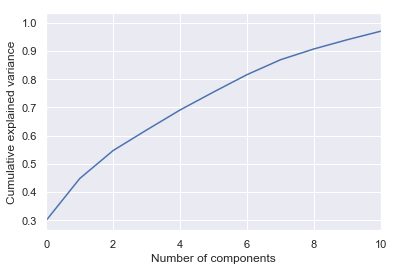

In [363]:
pca = PCA().fit(numeric_features_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,10,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [364]:
explained_variance = pca.explained_variance_
explained_variance

array([4.19873859e+00, 2.07488152e+00, 1.39110108e+00, 1.01916677e+00,
       9.93363485e-01, 8.90189986e-01, 8.62361530e-01, 7.38409723e-01,
       5.35890693e-01, 4.58607790e-01, 4.22780626e-01, 2.43361096e-01,
       1.73152037e-01, 1.75649550e-03])

In [354]:
def plot_pca_explained_variance_ratio(explained_variance):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

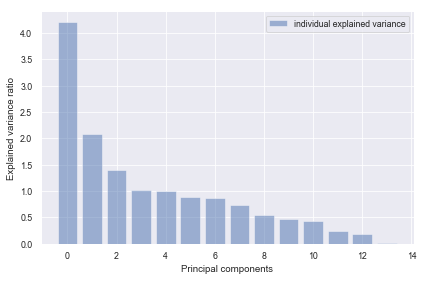

In [355]:
plot_pca_explained_variance_ratio(explained_variance)

In [358]:
def plot_pca_projections(scaled_features):
    pca = PCA(n_components=5)
    X_Train = pca.fit_transform(scaled_features)

    sns.set(style='darkgrid')
    f, ax = plt.subplots(figsize=(8, 8))
    # ax.set_aspect('equal')
    ax = sns.kdeplot(X_Train[:,0], X_Train[:,1], cmap="Greens",
              shade=True, shade_lowest=False)
    ax = sns.kdeplot(X_Train[:,1], X_Train[:,2], cmap="Reds",
              shade=True, shade_lowest=False)
    ax = sns.kdeplot(X_Train[:,2], X_Train[:,3], cmap="Blues",
              shade=True, shade_lowest=False)
    red = sns.color_palette("Reds")[-2]
    blue = sns.color_palette("Blues")[-2]
    green = sns.color_palette("Greens")[-2]
    ax.text(0.5, 0.5, "2nd and 3rd Projection", size=12, color=blue)
    ax.text(-4, 0.0, "1st and 3rd Projection", size=12, color=red)
    ax.text(2, 0, "1st and 2nd Projection", size=12, color=green)
    plt.xlim(-6, 5)
    plt.ylim(-2, 2)

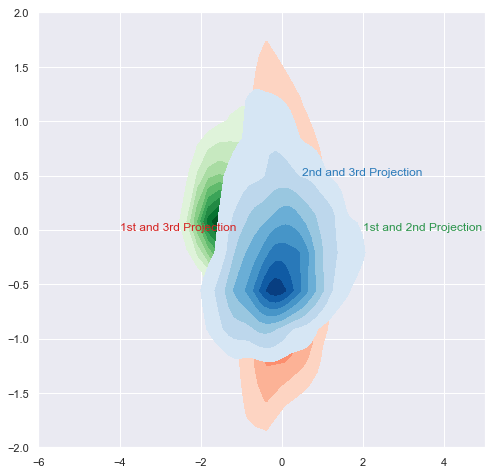

In [359]:
plot_pca_projections(numeric_features_scaled)

### Training Models on Numeric Features

In [288]:
numeric_dataset_split = dataset_split(numeric_features_scaled, movie_labels)

In [329]:
train_and_score_baseline_model(
    dataset_split=numeric_dataset_split,
    algorithm=LinearRegression
)

parameters = {
    'fit_intercept': [True, False], 
    'normalize': [True, False],
    'copy_X': [True, False]
}
train_and_score_tunned_model(
    dataset_split=numeric_dataset_split,
    algorithm=LinearRegression,
    tunned_params=parameters
)

Baseline Algorithm:
	Training score:  0.3637727468541343
	Testing score:  0.337312498931408
Tunned Algorithm:
	Best parameters:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
	Best estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
	Training score:  0.3637727468541343
	Testing score:  0.33731249893140824


In [336]:
train_and_score_baseline_model(
    dataset_split=numeric_dataset_split,
    algorithm=Ridge
)
parameters = {
    'alpha': [1.0, 3.0, 5.0], 
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'max_iter': [1000, 5000, 10000],
}
train_and_score_tunned_model(
    dataset_split=numeric_dataset_split,
    algorithm=Ridge,
    tunned_params=parameters
)

Baseline Algorithm:
	Training score:  0.3636742701949733
	Testing score:  0.3367377252545096
Tunned Algorithm:
	Best parameters:  {'alpha': 3.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False}
	Best estimator:  Ridge(alpha=3.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
	Training score:  0.3632556401026741
	Testing score:  0.33583138587020755


In [305]:
train_and_score_baseline_model(
    dataset_split=numeric_dataset_split,
    algorithm=RandomForestRegressor
)

#WARNING: Too slow
#parameters = {
#    'n_estimators': [5, 10, 100],
#    'criterion': ['mse', 'mae'],
#    'max_depth': [None, 100, 1000, 10000], 
#    'max_leaf_nodes': [None, 100, 1000, 10000]
#}
#train_and_score_tunned_model(
#    dataset_split=numeric_dataset_split,
#    algorithm=RandomForestRegressor,
#    tunned_params=parameters
#)

Baseline Algorithm:
	Training score:  0.9128296514960361
	Testing score:  0.5359678390749217


In [337]:
train_and_score_baseline_model(
    dataset_split=numeric_dataset_split,
    algorithm=SVR
)

#WARNING: Too slow
#parameters = {
#    'kernel': ['rbf', 'linear', 'poly'],
#    'poly': [3, 5, 7],
#    'epsilon': [0.1, 0.01, 0.001]
#}
#train_and_score_tunned_model(
#    dataset_split=numeric_dataset_split,
#    algorithm=SVR,
#    tunned_params=parameters
#)

Baseline Algorithm:
	Training score:  0.5372557045358297
	Testing score:  0.49644847790829827


In [338]:
train_and_score_baseline_model(
    dataset_split=numeric_dataset_split,
    algorithm=KNeighborsRegressor
)

#WARNING: Too slow
#parameters = {
#   'n_neighbors': [3, 5, 10],
#   'weights': ['uniform', 'distance'],
#   'leaf_size': [30, 10, 50],
#   'p': [1, 2, 3]
#}
#train_and_score(
#    dataset_split=numeric_dataset_split,
#    algorithm=KNeighborsRegressor
#)

Baseline Algorithm:
	Training score:  0.5695708441322973
	Testing score:  0.3450515499129927


### Categorical Features
Now let us deal with categorical features. First need to filter them out. We will generate dummy features based on available values and remove some inapropriate ones, e.g. NaN value, etc.

In [246]:
def get_categorical_feature_dummies(dataset, feature_names):
    for feat in feature_names:
        dataset = pd.concat([dataset, pd.get_dummies(dataset[feat], prefix=feat, dummy_na=True)], axis=1)
    return dataset

movie_feature_dummies = get_categorical_feature_dummies(movie_features, categorical_feature_names)
movie_feature_dummies_names = movie_feature_dummies.columns.values.tolist()

excluded_feature_names = numeric_feature_names + text_feature_names + ['title_year', 'title_year_nan', 'color_nan']

categorical_dummies_names = [i for i in movie_feature_dummies_names if i not in excluded_feature_names]
categorical_dummies_names[-5:]

['title_year_2012.0',
 'title_year_2013.0',
 'title_year_2014.0',
 'title_year_2015.0',
 'title_year_2016.0']

Next step will be to filter those features that have strong correlations. We will use Pearson's coefficient to achieve that. Then we will grab the first and last 10 sorted by the coefficient which will mean that they will intersect by symmetrical values below and above 0.

In [360]:
def calculate_pearson_coefficient(dataset, labels, feature_names):
    correl = {}
    for f in feature_names:
        correl[f] = pearsonr(dataset[f], labels)
    return sorted(correl.items(), key=operator.itemgetter(1), reverse=True)
    
all_coefficients = calculate_pearson_coefficient(movie_feature_dummies, movie_labels, categorical_dummies_names)
top10_positively_corr_features = [i[0] for i in all_coefficients[0:10]]
top10_negatively_corr_features = [i[0] for i in all_coefficients[-10:]]
print('Top 10 positively correlated features: ', top10_positively_corr_features)
print('')
print('Top 10 negaitively correlated features: ', top10_negatively_corr_features)

/Users/ceco/.virtualenvs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Top 10 positively correlated features:  ['color_ Black and White', 'genres_Drama', 'genres_Crime|Drama', 'director_name_Christopher Nolan', 'genres_Drama|Romance', 'director_name_Steven Spielberg', 'director_name_Quentin Tarantino', 'director_name_Martin Scorsese', 'actor_1_name_Leonardo DiCaprio', 'actor_1_name_Tom Hanks']

Top 10 negaitively correlated features:  ['actor_3_name_Fred Willard', 'actor_3_name_David Backus', 'actor_3_name_John Topor', 'actor_3_name_Karin Konoval', 'content_rating_PG', 'actor_3_name_Eva Marcille', "actor_3_name_Lil' Wayne", 'actor_3_name_Peter Wingfield', 'content_rating_PG-13', 'country_USA']


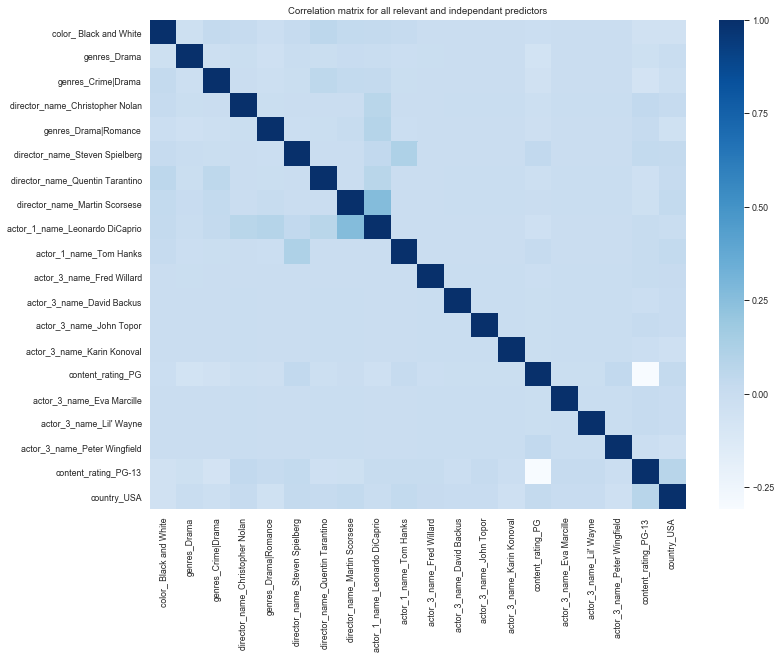

In [275]:
def corrmap(dataset, feature_names, title):
    #sns.set(context="paper")
    corrmat = dataset[feature_names].corr()
    f, ax = plt.subplots(figsize=(12, 9))
    plt.title(title)
    sns.heatmap(corrmat, cmap="Blues")
    
relevant_feature_names = top10_positively_corr_features + top10_negatively_corr_features
    
corrmap(
    dataset=movie_feature_dummies, 
    feature_names=relevant_feature_names, 
    title="Correlation matrix for all relevant and independant predictors"
)

In [276]:
relevant_features = movie_feature_dummies[relevant_feature_names]
movie_feature_dummies_split = dataset_split(relevant_features, movie_labels)

### Training Models on Categorical Features

In [339]:
train_and_score_baseline_model(
    dataset_split=movie_feature_dummies_split,
    algorithm=LinearRegression
)

parameters = {
    'fit_intercept': [True, False], 
    'normalize': [True, False],
    'copy_X': [True, False]
}
train_and_score_tunned_model(
    dataset_split=movie_feature_dummies_split,
    algorithm=LinearRegression,
    tunned_params=parameters
)

Baseline Algorithm:
	Training score:  0.1513853987131346
	Testing score:  0.09845978725178463
Tunned Algorithm:
	Best parameters:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
	Best estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
	Training score:  0.1513853987131346
	Testing score:  0.09845978725178482


In [340]:
train_and_score_baseline_model(
    dataset_split=movie_feature_dummies_split,
    algorithm=Ridge
)
parameters = {
    'alpha': [1.0, 3.0, 5.0], 
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'max_iter': [1000, 5000, 10000],
}
train_and_score_tunned_model(
    dataset_split=movie_feature_dummies_split,
    algorithm=Ridge,
    tunned_params=parameters
)

Baseline Algorithm:
	Training score:  0.14398710579752616
	Testing score:  0.09915857828876407
Tunned Algorithm:
	Best parameters:  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False}
	Best estimator:  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
	Training score:  0.14398710579752616
	Testing score:  0.09915857828876407


In [343]:
train_and_score_baseline_model(
    dataset_split=movie_feature_dummies_split,
    algorithm=RandomForestRegressor
)

#WARNING: Too slow
#parameters = {
#    'n_estimators': [5, 10, 100],
#    'criterion': ['mse', 'mae'],
#    'max_depth': [None, 100, 1000, 10000], 
#    'max_leaf_nodes': [None, 100, 1000, 10000]
#}
#train_and_score_tunned_model(
#    dataset_split=movie_feature_dummies_split,
#    algorithm=RandomForestRegressor,
#    tunned_params=parameters
#)

Baseline Algorithm:
	Training score:  0.15918667933103892
	Testing score:  0.09992633768600279


In [345]:
train_and_score_baseline_model(
    dataset_split=movie_feature_dummies_split,
    algorithm=SVR
)

#WARNING: Too slow
#parameters = {
#    'kernel': ['rbf', 'linear', 'poly'],
#    'poly': [3, 5, 7],
#    'epsilon': [0.1, 0.01, 0.001]
#}
#train_and_score_tunned_model(
#    dataset_split=movie_feature_dummies_split,
#    algorithm=SVR,
#    tunned_params=parameters
#)

Baseline Algorithm:
	Training score:  0.10022693390898607
	Testing score:  0.07559905533776066


In [346]:
train_and_score_baseline_model(
    dataset_split=movie_feature_dummies_split,
    algorithm=KNeighborsRegressor
)

#WARNING: Too slow
#parameters = {
#   'n_neighbors': [3, 5, 10],
#   'weights': ['uniform', 'distance'],
#   'leaf_size': [30, 10, 50],
#   'p': [1, 2, 3]
#}
#train_and_score_tunned_model(
#    dataset_split=movie_feature_dummies_split,
#    algorithm=KNeighborsRegressor,
#    tunned_params=parameters
#)

Baseline Algorithm:
	Training score:  -0.22042398054130885
	Testing score:  -0.13614004818720704


## Conclusion
In this analysis we used a dataset containing 5000 popular movies from IMDB with related metadata and tried to cleanup and preprocess the data and model predictions about a certain movie's rating. The results were far from satisfying. First we filtered out all numerical features, normalized them and applied Linear Regreassion, Ridge Regression, Random Forests, Support Vector Machines and KNN models. The accuracy scores were ranging from 30 to 50 percent which does not give an accurate insight about a movie's rating. Categorical features performed even worse. We applied Pearson's coefficient to find correlating features and used them to feed again our 5 above mentioned models. The results were even worse - between 10 to 15 percent accuracy. Something to notice was that although each algorithm works very differently, we still got similar results. Grid search optimized versions (or at least those that were with presented results in this analysis) also got similar results. The conclusion could be that there is really no connection between the dataset's features and the movie's ratings, or at least one that could be statistically expressed.

### References
[1] Pandas, "Pandas Documentation", https://pandas.pydata.org/pandas-docs/stable/

[2] Seaborn, "Seaborn Documentation", https://seaborn.pydata.org/
    
[3] Sci-Kit Learn, "Sci-Kit Learn Documentation", http://scikit-learn.org/stable/documentation.html

[4] Wikipedia, "Pearson correlation coefficient", https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[5] PCA, "Principal Component Analysis", http://setosa.io/ev/principal-component-analysis/